## Part-1 Task-2 Using Attention Layer and Pre-Trained Embeddings
#### Name: Ishaan Sinha
#### Roll Number: 21CS30064

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from matplotlib import pyplot

In [2]:
from datasets import load_dataset

# Load the full CNN/Daily Mail dataset (train split)
ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Check the size of the train dataset
total_size = len(ds['train'])
print(f"Total size of the dataset: {total_size}")

# Take a 10% sample of the dataset
sample_size = int(0.1 * total_size)  # Calculate 10% of the dataset
ds2 = ds['train'].shuffle(seed=42).select(range(sample_size))
# Check the size of the sampled dataset
total_sample_size = len(ds2)
print(f"Total size of the sampled dataset: {total_sample_size}")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Total size of the dataset: 287113
Total size of the sampled dataset: 28711


In [3]:
# Convert the sampled dataset into a DataFrame with columns 'text' and 'summary'
df = pd.DataFrame({
    'text': ds2['article'],  # Use 'article' field for the text
    'summary': ds2['highlights']  # Use 'highlights' field for the summary
})

In [4]:
#Reducing the length of dataset for better training and performance
df.drop_duplicates(subset=['text'],inplace=True) #Dropping the rows with Duplicates values of 'Text'  
df.dropna(axis=0,inplace=True) #Dropping the rows with Missing values 

In [5]:
#Dictionary for expanding the contractions
Mapping_for_Contraction = {
    "he's": "he is", "you'll": "you will", "y'all'd": "you all would", "mightn't've": "might not have", "shan't": "shall not",
    "there'd": "there would", "i'd've": "i would have", "she'd": "she would", "you'd've": "you would have", "it'll": "it will",
    "couldn't": "could not", "it'd've": "it would have", "i've": "i have", "who's": "who is", "shan't've": "shall not have",
    "i'll": "i will", "won't": "will not", "i'm": "i am", "isn't": "is not", "wouldn't've": "would not have", "they'd've": "they would have",
    "who've": "who have", "she'll": "she will", "haven't": "have not", "she'll've": "she will have", "mightn't": "might not",
    "shouldn't've": "should not have", "we've": "we have", "where's": "where is", "what's": "what is", "they're": "they are",
    "oughtn't": "ought not", "needn't": "need not", "he'd": "he would", "weren't": "were not", "they've": "they have",
    "won't've": "will not have", "that'd": "that would", "i'd": "i would", "here's": "here is", "shouldn't": "should not",
    "you'd": "you would", "mayn't": "may not", "that'd've": "that would have", "when've": "when have", "she'd've": "she would have",
    "y'all've": "you all have", "you've": "you have", "you're": "you are", "let's": "let us", "they'll": "they will",
    "mustn't": "must not", "when's": "when is", "what'll": "what will", "who'll": "who will", "ain't": "is not", 
    "they'll've": "they will have", "so've": "so have", "you'll've": "you will have", "it'd": "it would", 
    "this's": "this is", "he'll": "he will", "we're": "we are", "mustn't've": "must not have", "here's": "here is",
    "to've": "to have", "why've": "why have", "how'd": "how did", "they'd": "they would", "could've": "could have",
    "o'clock": "of the clock", "ma'am": "madam", "doesn't": "does not", "we'd": "we would", "what've": "what have",
    "needn't've": "need not have", "hasn't": "has not", "so's": "so as", "can't": "cannot", "couldn't've": "could not have",
    "shalln't": "shall not", "they're": "they are", "you've": "you have", "won't": "will not", "didn't": "did not",
    "what're": "what are", "aren't": "are not", "where'd": "where did", "he'll've": "he will have", "what'll've": "what will have",
    "hadn't": "had not", "where've": "where have", "will've": "will have", "he'd've": "he would have", "she's": "she is",
    "it'll've": "it will have", "we'd've": "we would have", "'cause": "because", "we'll": "we will", "isn't": "is not",
    "how'll": "how will", "wouldn't": "would not", "shalln't": "shall not", "why's": "why is", "where've": "where have",
    "it'll've": "it will have", "y'all": "you all", "aren't": "are not", "he'll": "he will", "oughtn't've": "ought not have",
    "couldn't": "could not", "who'll've": "who will have", "y'all'd've": "you all would have", "how'd'y": "how do you",
    "you'd've": "you would have", "couldn't've": "could not have", "we'll've": "we will have", "how's": "how is",
    "didn't": "did not", "could've": "could have", "haven't": "have not", "where's": "where is", "he'll": "he will",
    "must've": "must have", "wasn't": "was not", "might've": "might have", "you've": "you have", "i'm": "i am",
    "there's": "there is", "y'all're": "you all are", "what's": "what is", "hadn't've": "had not have",
    "they've": "they have", "we'll": "we will", "they're": "they are", "couldn't": "could not", "he'll've": "he will have"
}


In [6]:
# Downloading stopwords from NLTK if not already downloaded
nltk.download('stopwords')

# Creating a set of stop words for filtering
stop_words = set(stopwords.words('english'))

def clean_text(text, include_stopwords=False):
    # Converting text to lowercase
    text = text.lower()
    
    # Parsing HTML content to extract plain text
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Removing text within parentheses
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Removing double quotes
    text = text.replace('"', '')
    
    # Expanding contractions
    text = ' '.join([Mapping_for_Contraction.get(word, word) for word in text.split()])
    
    # Removing possessives and other 's forms
    text = re.sub(r"\b's\b", '', text)
    
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Splitting text into tokens and filtering stop words if specified
    tokens = text.split()
    if not include_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Keeping only words with more than one character
    filtered_words = [token for token in tokens if len(token) > 1]
    
    # Joining the filtered tokens back into a cleaned string
    return ' '.join(filtered_words).strip()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Text Cleaning
text_after_cleaning = []       #Using the clean_text function for cleaning text
for t in df['text']:
    text_after_cleaning.append(clean_text(t,0))

In [8]:
#Summary Cleaning 
summary_after_cleaning = []    #Using the clean_text function for cleaning summary as well
for t in df['summary']:
    summary_after_cleaning.append(clean_text(t,1))

/tmp/ipykernel_23/1996125555.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()


In [9]:
df['Cleaned_Text'] = text_after_cleaning        #Adding text_after_cleaning to the dataset
df['Cleaned_Summary'] = summary_after_cleaning  #Adding summary_after_cleaning to the dataset
#Dropping off the Empty Rows
df['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping off the Rows with Missing values
df.dropna(axis=0,inplace=True)

/tmp/ipykernel_23/3080299025.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cleaned_Summary'].replace('', np.nan, inplace=True)


In [10]:
word_count_of_text = []
word_count_of_summary = []

#Populating the lists with sentence lengths
for i in df['Cleaned_Text']:
      word_count_of_text.append(len(i.split()))

for i in df['Cleaned_Summary']:
      word_count_of_summary.append(len(i.split()))

In [11]:
#Function for getting the Maximum Review length  
count=0 
for i in df['Cleaned_Text']:
    if(len(i.split())<=1000):
        count=count+1
print(count/len(df['Cleaned_Text']))

0.9974544947346398


In [12]:
#Function for getting the Maximum Summary length
count=0
for i in df['Cleaned_Summary']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(df['Cleaned_Summary']))

0.9840993095752842


In [13]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 1000
max_summary_len = 100

latent_dim = 256
embedding_dim = 300

In [14]:
#Adding START and END tags to summary for better decoding
text_after_cleaning = np.array(df['Cleaned_Text'])
summary_after_cleaning = np.array(df['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(text_after_cleaning)):
    if(len(summary_after_cleaning[i].split())<=max_summary_len and len(text_after_cleaning[i].split())<=max_text_len):
        short_text.append(text_after_cleaning[i])
        short_summary.append(summary_after_cleaning[i])
        
df2=pd.DataFrame({'text':short_text,'summary':short_summary})

In [15]:
df2['summary'] = df2['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [16]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df2['text']),np.array(df2['summary']),test_size=0.2,random_state=0,shuffle=True)

In [17]:
!pip install gensim
from gensim import models

word2vec_path = '/kaggle/input/googlenews-vector/other/default/1/GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [18]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [19]:
#Preparing Tokenizer

#Text Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#preparing a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

In [20]:
#Rarewords and their coverage in review
thresh = 4  #If a word whose count is less than threshold i.e 4, then it's considered as rare word 

cnt = 0      #denotes no. of rare words whose count falls below threshold
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 53.381970584811214
Total Coverage of rare words: 1.2404762643944707


In [21]:
#Defining the Tokenizer with top most common words for reviews

#Preparing a Tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

X_word_index = X_tokenizer.word_index

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [22]:
X_voc

60066

In [23]:
X_embedding_weights = np.zeros((len(X_word_index)+1, embedding_dim))
for word,index in X_word_index.items():
    X_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print(X_embedding_weights.shape)

(128846, 300)


In [24]:
#Summary Tokenizer

#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [25]:
#Rarewords and their coverage in summary

thresh = 6  ##If a word whose count is less than threshold i.e 6, then it's considered as rare word 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.65899274452647
Total Coverage of rare words: 5.935428564415186


In [26]:
#Defining Tokenizer with the most common words in summary

#Preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)

y_word_index = y_tokenizer.word_index

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_voc

12851

In [28]:
y_embedding_weights = np.zeros((len(y_word_index)+1, embedding_dim))
for word,index in y_word_index.items():
    y_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print(y_embedding_weights.shape)

(47000, 300)


In [29]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(22526, 22526)

In [30]:
#Deleting rows containing START and END tokens
#For Training set
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [31]:
#For Validation set
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [32]:
#Model Building

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention.
    There are three sets of weights introduced W_a, U_a, and V_a.
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        
        # Create trainable weight variables for the layer
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=False)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=False)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[0][2], 1),
                                   initializer='uniform',
                                   trainable=False)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        if verbose:
            print('encoder_out_seq shape:', encoder_out_seq.shape)
            print('decoder_out_seq shape:', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            # Computing S.Wa where S=[s0, s1, ..., si]
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))

            # Computing hj.Ua
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)

            # tanh(S.Wa + hj.Ua)
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))

            # softmax(va.tanh(S.Wa + hj.Ua))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_initial_state(inputs, hidden_size):
            # Initial state for K.rnn
            fake_state = K.zeros_like(inputs)
            fake_state = K.sum(fake_state, axis=[1, 2])
            fake_state = K.expand_dims(fake_state)
            fake_state = K.tile(fake_state, [1, hidden_size])
            return fake_state

        fake_state_c = create_initial_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_initial_state(encoder_out_seq, encoder_out_seq.shape[1])

        # Computing energy outputs
        _, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e]
        )

        # Computing context vectors
        _, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        # Output shapes
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [33]:
len(X_word_index)+1

128846

In [34]:
from tensorflow.keras import backend as K
K.clear_session()  #Resets all state generated by Keras

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(len(X_word_index)+1, embedding_dim, weights=[X_embedding_weights],input_length=max_text_len,trainable=False)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer
dec_emb_layer = Embedding(len(y_word_index)+1, embedding_dim, weights=[y_embedding_weights],input_length=max_summary_len, trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Defining the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 300) │ 38,653,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 1000,     │    570,368 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1000,     │    525,312 │ lstm[0][0]        │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │ 14,100,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 1000,     │    525,312 │ lstm_1[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    570,368 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    131,328 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 256), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 1000)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  6,592,563 │ concat_layer[0][… │
│ (TimeDistributed)   │ 12851)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,669,051 (235.25 MB)

 Trainable params: 8,783,923 (33.51 MB)

 Non-trainable params: 52,885,128 (201.74 MB)

In [35]:
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Training the Model
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size= 64, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.5627 - loss: 3.8806 - val_accuracy: 0.5908 - val_loss: 3.1290
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.5887 - loss: 3.1681 - val_accuracy: 0.5998 - val_loss: 3.0417
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.5978 - loss: 3.0565 - val_accuracy: 0.6070 - val_loss: 2.9490
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.6057 - loss: 2.9590 - val_accuracy: 0.6103 - val_loss: 2.8930
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.6090 - loss: 2.9038 - val_accuracy: 0.6138 - val_loss: 2.8434
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.6124 - loss: 2.8481 - val_accuracy: 0.6151 - val_loss: 2.8093
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.6142 - loss: 2.8081 - val_accuracy: 0.6164 - val_loss: 2.7783
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.6156 - loss: 2.7760 - val_accu

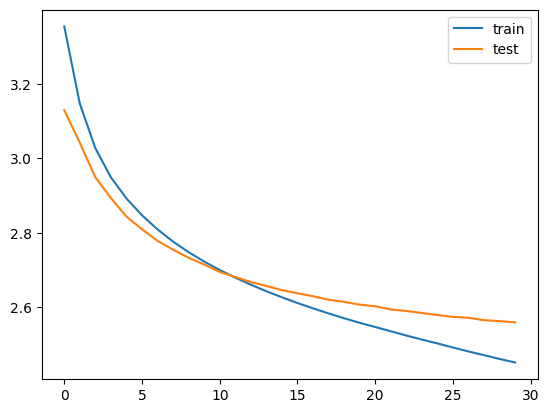

In [36]:
#Visualizing Loss 
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [37]:
#Building Dictionary for Source Vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [38]:
#Inference/Validation Phase
#Encoding the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#These tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Getting the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

#Setting the initial states to the states from the previous time step for better prediction
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

#Final Decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
#Function defining the implementation of inference process
def decode_sequence(input_seq):
    #Encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    #Populating the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        #Sampling a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        #Exit condition: either hit max length or find stop word
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        #Updating the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Updating internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
#Functions to convert an integer sequence to a word sequence for summary as well as reviews 
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [41]:
#Summaries generated by the model

for i in range(0,20):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: daily mail reporter published est february updated est february beyonce wowed millions around world spectacular super bowl performance sunday may halftime show next year new jersey cold super bowl first played outdoors cold weather conditions centerpiece performance may casualty freezing temperatures revealed today new york post reported plans musical show metlife stadium new jersey nfl officials cannot work put huge spectacle wintry conditions fierce beyonce delighted millions fans around world energetic sexy performance super bowl halftime show sunday powerful beyonce joined dancers performance super bowl may halftime show next year beyonce grabbed share headlines alongside minute power outage baltimore ravens narrow victory san francisco ers sunday monday speculation immediately began would play next year event local rockers bruce springsteen bon jovi early favorites nfl officials leaked actually plans sort musical performance cold weather one source told post acts singers a

In [42]:
!pip install rouge-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d6e501af13adab839d80ef89c9abaa1f260d6848f52a51b1a1acad84b353bc85
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [43]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(N=20):
    rouge_2 = 0
    rouge_l = 0
    
    # Initialize the ROUGE scorer for ROUGE-2 and ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

    for i in range(N):
        ref = seq2summary(y_test[i])  # Reference summary
        hypo = decode_sequence(X_test[i].reshape(1, max_text_len))  # Hypothesis generated summary

        # Compute the ROUGE scores
        scores = scorer.score(ref, hypo)

        # Accumulate ROUGE-2 and ROUGE-L F1 scores
        rouge_2 += scores['rouge2'].fmeasure
        rouge_l += scores['rougeL'].fmeasure

    # Average the scores over N examples
    rouge_2_avg = rouge_2 / N
    rouge_l_avg = rouge_l / N
    
    print("ROUGE-2:%.4f ROUGE-L:%.4f" % (rouge_2_avg, rouge_l_avg))

# Call the function to calculate the ROUGE scores
calculate_rouge_scores()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━